In [ ]:
from IPython.display import clear_output

def install_xvfb():
    import os
    import sys

    if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
        !touch .setup_complete

    # This code creates a virtual display to draw game images on.
    # It will have no effect if your machine has a monitor.
    if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
        !bash ../xvfb start
        os.environ['DISPLAY'] = ':1'

    clear_output()

In [ ]:
%matplotlib inline

install_xvfb()

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

# Task 1. MountainCar

## OpenAI Gym

We're gonna spend several next weeks learning algorithms that solve decision processes. We are then in need of some interesting decision problems to test our algorithms.

That's where OpenAI Gym comes into play. It's a Python library that wraps many classical decision problems including robot control, videogames and board games.

So here's how it works:

In [ ]:
import gym

env = gym.make('MountainCar-v0'); env.reset()

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)


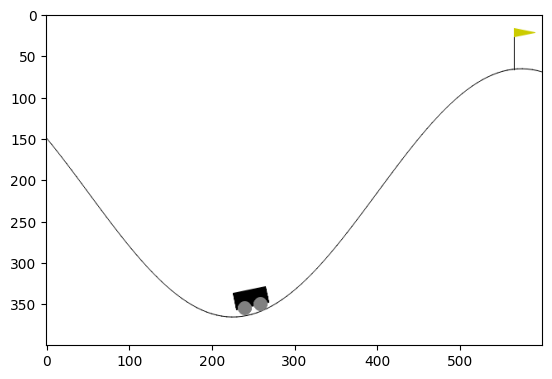

In [ ]:
plt.imshow(env.render('rgb_array'))
plt.show()

Note: if you're running this on your local machine, you'll see a window pop up with the image above. Don't close it, just alt-tab away.

## Gym interface

The three main methods of an environment are
* `reset()`: reset environment to the initial state, _return first observation_
* `render()`: show current environment state (a more colorful version :) )
* `step(a)`: commit action `a` and return `(new_observation, reward, is_done, info)`
 * `new_observation`: an observation right after committing the action `a`
 * `reward`: a number representing your reward for committing action `a`
 * `is_done`: True if the MDP has just finished, False if still in progress
 * `info`: some auxiliary stuff about what just happened. For now, ignore it.

In [ ]:
print("initial observation code:", *env.reset())

# Note: in MountainCar, observation is just two numbers: car position and velocity

initial observation code: -0.5526259 0.0


In [ ]:
print("taking action 2 (right)")
new_obs, reward, is_done, _ = env.step(2)

print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)

# Note: as you can see, the car has moved to the right slightly (around 0.0005)

taking action 2 (right)
new observation code: [-0.54898274  0.00242576]
reward: -1.0
is game over?: False


## Play with it

Below is the code that drives the car to the right. However, if you simply use the default policy, the car will not reach the flag at the far right due to gravity.

__Your task__ is to fix it. Find a strategy that reaches the flag.

You are not required to build any sophisticated algorithms for now, and you definitely don't need to know any reinforcement learning for this. Feel free to hard-code :)

In [ ]:
from IPython.display import display

# Create env manually to set time limit. Please don't change this.
TIME_LIMIT = 250
env = gym.wrappers.TimeLimit(
    gym.envs.classic_control.MountainCarEnv(),
    max_episode_steps=TIME_LIMIT + 1,
)
actions = {'left': 0, 'stop': 1, 'right': 2}; clear_output()

In [ ]:
def policy(obs, t):
    position, velocity = obs
    if velocity < 0:
        return actions['left']
    else:
        return actions['right']

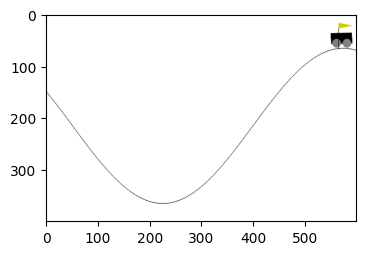

In [ ]:
plt.figure(figsize=(4, 3))
clear_output(wait=True)

obs = env.reset()
for t in range(TIME_LIMIT):
    plt.gca().clear()

    action = policy(obs, t)  # Call your policy
    obs, reward, done, _ = env.step(action)  # Pass the action chosen by the policy to the environment

    # We don't do anything with reward here because MountainCar is a very simple environment,
    # and reward is a constant -1. Therefore, your goal is to end the episode as quickly as possible.

    # Draw game image on display.
    plt.imshow(env.render('rgb_array'))

    display(plt.gcf())
    clear_output(wait=True)

    if done:
        print("Well done!")
        break
else:
    print("Time limit exceeded. Try again.")

clear_output(wait=True)

In [ ]:
assert obs[0] > 0.47
print("You solved it!")

You solved it!


# Task 2. CartPole

Just like we did before for Q-learning, this time we'll design a PyTorch network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from approximate Q-learning, so you'll find it more or less familiar and even simpler.

In [ ]:
!pip install -q gym[classic_control]==0.26.0
!pip install moviepy
!apt install ffmpeg
!pip install imageio-ffmpeg

install_xvfb()

In [ ]:
from IPython.display import clear_output

import gym
print(f'gym version: {gym.__version__}')
assert tuple(map(int, gym.__version__.split('.')))[:2] >= (0, 26)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

gym version: 0.26.0


A caveat: with some versions of `pyglet`, the following cell may crash with `NameError: name 'base' is not defined`. The corresponding bug report is [here](https://github.com/pyglet/pyglet/issues/134). If you see this error, try restarting the kernel.

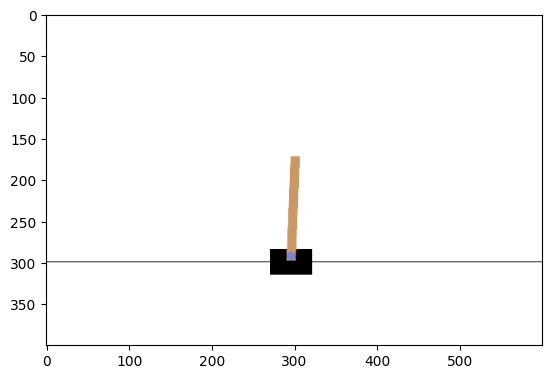

In [ ]:
env = gym.make("CartPole-v0", render_mode = "rgb_array")

# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render()); clear_output()

In [ ]:
import torch
import torch.nn as nn

In [ ]:
model = nn.Sequential(nn.Sequential(nn.Linear(4, 100), nn.ReLU(), nn.Linear(100, 2)))

## Predict function

Note: output value of this function is not a torch tensor, it's a numpy array.
So, here gradient calculation is not needed.
<br>
Use [no_grad](https://pytorch.org/docs/stable/autograd.html#torch.autograd.no_grad)
to suppress gradient calculation.
<br>
Also, `.detach()` (or legacy `.data` property) can be used instead, but there is a difference:
<br>
With `.detach()` computational graph is built but then disconnected from a particular tensor,
so `.detach()` should be used if that graph is needed for backprop via some other (not detached) tensor;
<br>
In contrast, no graph is built by any operation in `no_grad()` context, thus it's preferable here.

In [ ]:
def predict_probs(states):
    """
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    return model(torch.as_tensor(states)).softmax(dim=-1).data.numpy()

In [ ]:
test_states = np.array([env.reset()[0] for _ in range(5)])
test_probas = predict_probs(test_states)
assert isinstance(test_probas, np.ndarray), \
    "you must return np array and not %s" % type(test_probas)
assert tuple(test_probas.shape) == (test_states.shape[0], env.action_space.n), \
    "wrong output shape: %s" % np.shape(test_probas)
assert np.allclose(np.sum(test_probas, axis=1), 1), "probabilities do not sum to 1"

## Play the game

We can now use our newly built agent to play the game.

In [ ]:
state, _ = env.reset()

In [ ]:
predict_probs(np.array([state])).squeeze(0)

array([0.58701223, 0.4129877 ], dtype=float32)

In [ ]:
def generate_session(env, t_max=1000, video_file = None):
    """
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []

    state, _ = env.reset()

    if video_file is not None:
        video = VideoRecorder(env, video_file)

    for t in range(t_max):
        # action probabilities array aka pi(a|s)
        action_probs = predict_probs(np.array([state])).squeeze(0)

        # Sample action with given probabilities.
        action = np.random.choice(a=np.arange(0, len(action_probs)), p=action_probs)

        if video_file is not None:
            env.render()
            video.capture_frame()

        states.append(state)
        state, reward, is_done, _, _ = env.step(action)

        actions.append(action)
        rewards.append(reward)

        if is_done: break

    if video_file is not None:
        video.close()

    return states, actions, rewards

In [ ]:
# test it
states, actions, rewards = generate_session(env)

## Computing cumulative rewards

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots = \sum_{i = t}^T \gamma^{i - t} r_i = r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [ ]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).

    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    G = [rewards[-1]] * len(rewards)
    for i in reversed(range(len(rewards) - 1)):
        G[i] = rewards[i] + gamma * G[i + 1]
    return G

In [ ]:
get_cumulative_rewards(rewards)
assert len(get_cumulative_rewards(list(range(100)))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


## Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse PyTorch's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [ ]:
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot

In [ ]:
# Your code: define optimizers
optimizer = torch.optim.Adam(model.parameters(), 1e-3)


def train_on_session(states, actions, rewards, gamma=0.99, entropy_coef=1e-2):
    """
    Takes a sequence of states, actions and rewards produced by generate_session.
    Updates agent's weights by following the policy gradient above.
    Please use Adam optimizer with default parameters.
    """

    # cast everything into torch tensors
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int32)
    cumulative_returns = np.array(get_cumulative_rewards(rewards, gamma))
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)

    # predict logits, probas and log-probas using an agent.
    logits = model(states)
    probs = nn.functional.softmax(logits, -1)
    log_probs = nn.functional.log_softmax(logits, -1)

    assert all(isinstance(v, torch.Tensor) for v in [logits, probs, log_probs]), \
        "please use compute using torch tensors and don't use predict_probs function"

    # select log-probabilities for chosen actions, log pi(a_i|s_i)
    log_probs_for_actions = torch.sum(log_probs * to_one_hot(actions, env.action_space.n), dim=1)

    # Compute loss here. Don't forgen entropy regularization with `entropy_coef`
    entropy = - (log_probs * probs).sum(dim=1)
    loss = - log_probs_for_actions * cumulative_returns - entropy * entropy_coef

    # Gradient descent step
    loss.mean().backward()
    optimizer.step()
    optimizer.zero_grad()

    # technical: return session rewards to print them later
    return np.sum(rewards)

## The actual training

In [ ]:
model = nn.Sequential(nn.Sequential(nn.Linear(4, 100), nn.ReLU(), nn.Linear(100, 2)))
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

for i in range(100):
    rewards = [train_on_session(*generate_session(env)) for _ in range(100)]  # generate new sessions

    print("mean reward:%.3f" % (np.mean(rewards)))

    if np.mean(rewards) > 500:
        print("You Win!")  # but you can train even further
        break

mean reward:19.780
mean reward:24.650
mean reward:32.770
mean reward:29.820
mean reward:35.510
mean reward:50.630
mean reward:59.290
mean reward:77.430
mean reward:127.460
mean reward:153.360
mean reward:217.280
mean reward:223.840
mean reward:172.760
mean reward:201.930
mean reward:94.590
mean reward:123.250
mean reward:386.230
mean reward:317.560
mean reward:378.960
mean reward:304.530
mean reward:365.270
mean reward:385.180
mean reward:373.820
mean reward:532.260
You Win!


## Results & video

In [ ]:
# Record sessions
import os
from gym.wrappers.monitoring.video_recorder import VideoRecorder

if not os.path.exists('videos'):
    os.makedirs('videos')

sessions = [
    generate_session(
        gym.make("CartPole-v0", render_mode = "rgb_array"),  video_file = f'videos/CartPole_session_{i}.mp4')
    for i in range(2)]

Moviepy - Done !
Moviepy - video ready videos/CartPole_session_1.mp4


In [ ]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[-1]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))